<a href="https://colab.research.google.com/github/0525hhgus/Detect-Autism-from-Facial-Images/blob/main/DetectAutismCNNModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **인공 신경망을 활용한 자폐아 탐지**
- 신경망과 딥러닝 기말 프로젝트
- CNN

# 1. 환경 설정

## 1.1 라이브러리

In [ ]:
from tensorflow import keras
import tensorflow as  tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Dropout, MaxPooling2D,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D,  Flatten, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
from PIL import Image
# import optuna
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## 1.2 GPU 설정

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


# 2. 데이터

## 2-1. 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2-2. 데이터 불러오기

In [ ]:
dir=r'/content/drive/MyDrive/DetectAutismDataset/'

# 사전에 train, test, validation 데이터셋 분리
train_dir=os.path.join(dir,'train')
test_dir=os.path.join(dir,'test')
val_dir=os.path.join(dir,'valid')

## 2-3. 변수 및 파라미터 설정

In [ ]:
classes=os.listdir(train_dir)
batch_size=56 # 배치 크기
rand_seed=1220
start_epoch=0 # 시작 에폭
epochs=30 # 에폭
img_size=224 # 이미지 크기 : 224 X 224
lr=.001 # 학습률

In [ ]:
# validation, test 배치 설정 함수
def get_bs(dir,b_max):
    length=0
    dir_list=os.listdir(dir)
    for d in dir_list:
        d_path=os.path.join (dir,d)
        length=length + len(os.listdir(d_path))
    batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=b_max],reverse=True)[0]  
    return batch_size,int(length/batch_size)

In [ ]:
valid_batch_size, valid_steps=get_bs(val_dir, 100)
test_batch_size, test_steps=get_bs(test_dir,100)

## 2-4. 데이터 전처리
- 기존 이미지 데이터셋을 변형(가로 반전)하여 데이터 수를 늘림
- [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) 라이브러리 사용
- 총 데이터 수 2배

In [ ]:
# 이미지 인코딩 mobilenet 사용, 가로 반전 
# 폴더로부터 이미지 크기 224 X 224, categorical(2D 원핫 인코딩된 라벨), rgb(3 개 채널)

train_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input, horizontal_flip=True).flow_from_directory(
        train_dir,  target_size=(img_size, img_size), batch_size=batch_size, seed=rand_seed, class_mode='categorical', color_mode='rgb')

valid_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input) .flow_from_directory(val_dir, 
                    target_size=(img_size, img_size), batch_size=valid_batch_size,
                    class_mode='categorical',color_mode='rgb', shuffle=False)
test_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(test_dir,
                    target_size=(img_size, img_size), batch_size=test_batch_size,
                    class_mode='categorical',color_mode='rgb', shuffle=False )
test_file_names=test_gen.filenames  # 성능평가에 사용할 test 파일 이름
test_labels=test_gen.labels # 성능평가에 사용할 test 라벨

val_file_names=valid_gen.filenames  # 학습에 사용할 validation 파일 이름
val_labels=valid_gen.labels # 학습에 사용할 validation 라벨

Found 2536 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


## 2-5. 데이터 시각화
- 데이터 시각화 함수

In [ ]:
def show_images( test_dir, test_gen, preds, max_images ): 
  if max_images==0: 
    return new_dict 

  class_dict=test_gen.class_indices 

  for key,value in class_dict.items(): 
    new_dict[value]=key # class_dict { 클래스 숫자 : 클래스 이름 } 
    errors=0 
    labels= test_gen.labels 
    file_names= test_gen.filenames

  for i, p in enumerate(preds):
    if np.argmax(p) != labels[i]: # 분류되지 않은 라벨인 경우
        errors=errors + 1        
    rows=int(np.ceil(errors/3))
    height=rows * 5        
    plt.figure(figsize=(20,height ))
    j=1
    for i,p in enumerate(preds):
        if j <=max_images:
            if np.argmax(p) != labels[i]:  # 분류되지 않은 라벨인 경우
                error_class=new_dict(np.argmax(p))
                path_to_class=os.path.join(test_dir, error_class)
                class_file_list-os.listdir(path_to_class)
                path_to_error_img= class_file_list[0]
                img_path=os.path.join(test_dir,file_names[i] )
                plt.subplot(rows, 6, j)                
                j=j + 1
                img_true = Image.open(img_path)
                img_true=img_true.resize((224,224))
                img_error=Image.open(error_path)
                img_error=img_error.resize(224,224)
                plt.axis('off')
                title=file_names[i][:18]
                plt.title(title)
                plt.imshow(np.asarray(img_true)) 
                plt.imshow(np.asarray(img_error)) 
        else:
            break
    plt.show()
  return 

- 데이터 시각화

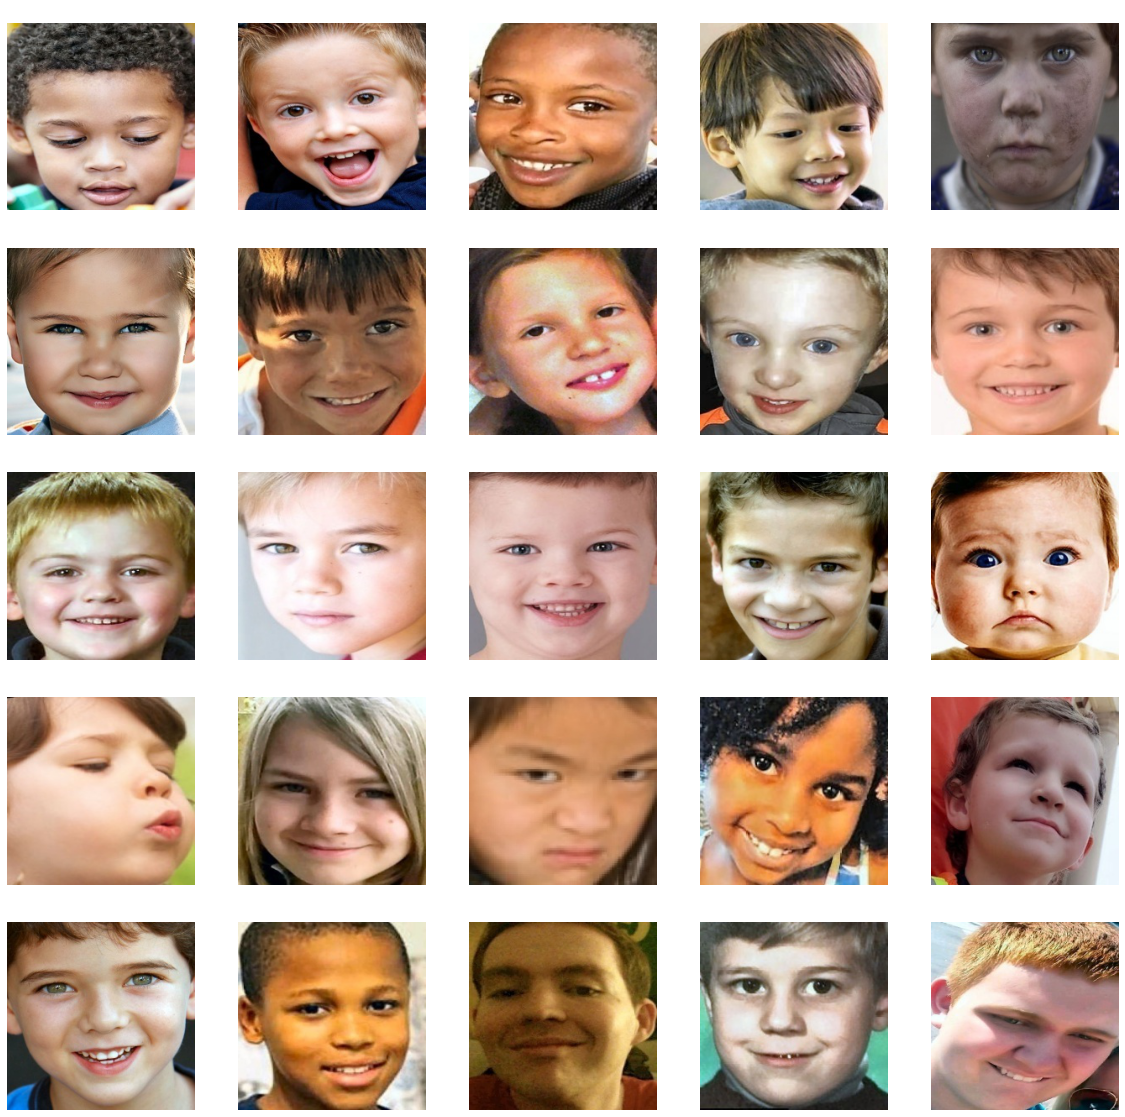

In [ ]:
images,labels=next(train_gen)
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    image=(images[i]+1 )/2
    plt.imshow(image)
    index=int(labels[i][1])
    plt.title(classes[index], color='white')
    plt.axis('off')
plt.show()

# 3. 모델

## 3-1. CNN 모델 정의

In [ ]:
model = Sequential()
input_shape = (224,224,3)
model.add(Conv2D(64, (10, 10), input_shape=input_shape,activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(Conv2D(64, (10, 10), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (10, 10),activation='relu',padding='same', kernel_initializer='he_normal'))
model.add(Conv2D(128, (10, 10),activation='relu',padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (6, 6),activation='relu',padding='same', kernel_initializer='he_normal'))
model.add(Conv2D(64, (6, 6),activation='relu',padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(Adamax(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)
mc = ModelCheckpoint('/content/drive/MyDrive/best_CNN_model.h5', monitor='val_loss', mode='min', save_best_only=True)

## 3-2. 모델 실행

In [ ]:
results = model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=[es, mc],  validation_data=valid_gen,
               validation_steps=valid_steps,  shuffle=True,  initial_epoch=start_epoch)

Epoch 1/30
46/46 [==============================] - 776s 17s/step - loss: 1.1677 - accuracy: 0.6307 - val_loss: 3.2188 - val_accuracy: 0.4900
Epoch 2/30
46/46 [==============================] - 76s 2s/step - loss: 0.5699 - accuracy: 0.7455 - val_loss: 0.6821 - val_accuracy: 0.6600
Epoch 3/30
46/46 [==============================] - 75s 2s/step - loss: 0.5368 - accuracy: 0.7514 - val_loss: 0.7896 - val_accuracy: 0.6700
Epoch 4/30
46/46 [==============================] - 75s 2s/step - loss: 0.5116 - accuracy: 0.7540 - val_loss: 0.5266 - val_accuracy: 0.7000
Epoch 5/30
46/46 [==============================] - 75s 2s/step - loss: 0.4713 - accuracy: 0.7734 - val_loss: 0.5543 - val_accuracy: 0.6800
Epoch 6/30
46/46 [==============================] - 75s 2s/step - loss: 0.4746 - accuracy: 0.7700 - val_loss: 0.5790 - val_accuracy: 0.6800
Epoch 7/30
46/46 [==============================] - 75s 2s/step - loss: 0.4060 - accuracy: 0.8264 - val_loss: 0.5050 - val_accuracy: 0.7700
Epoch 8/30
46/46 [

## 3-3. 모델 구조

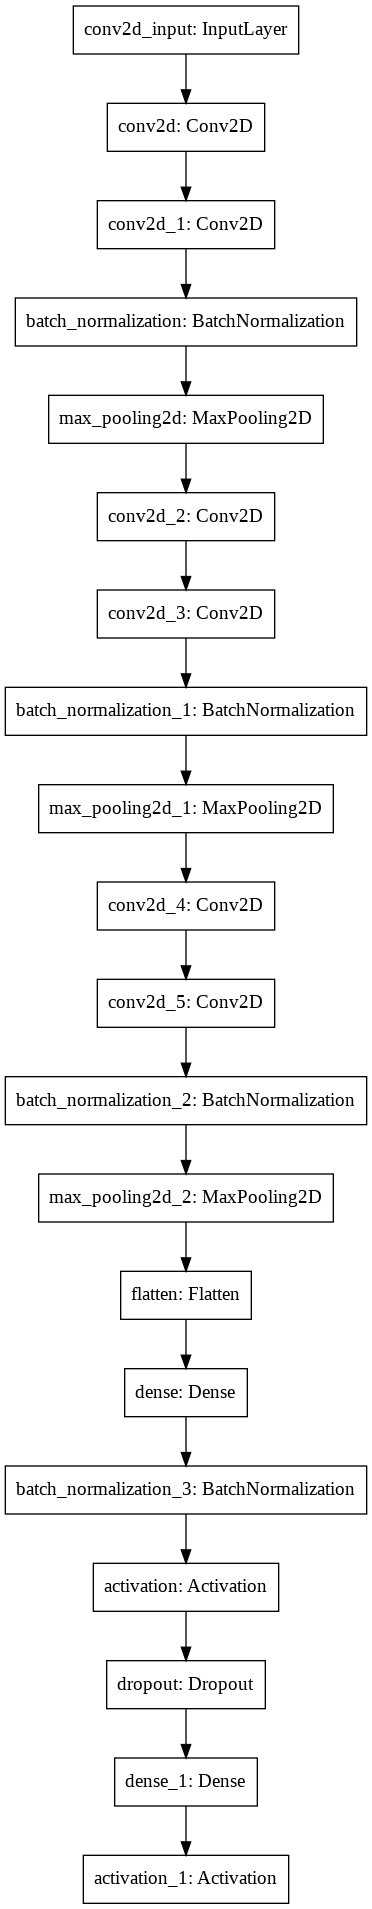

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/CNNmodelimage.png')

# 4. 성능평가

## 4-1. 학습 모델 정확도 및 오차 그래프

In [ ]:
# 학습 과정에서 Train, Validation 성능
def tr_plot(tr_data):
    history=tr_data.history
    tacc=results.history['accuracy']
    tloss=results.history['loss']
    vacc=results.history['val_accuracy']
    vloss=results.history['val_loss']
    Epoch_count=len(tloss)
    Epochs=[]
    for i in range (0,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss) # 가장 적은 validation 오차
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    val_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1)
    vc_label='best epoch= '+ str(index_acc + 1)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1,val_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

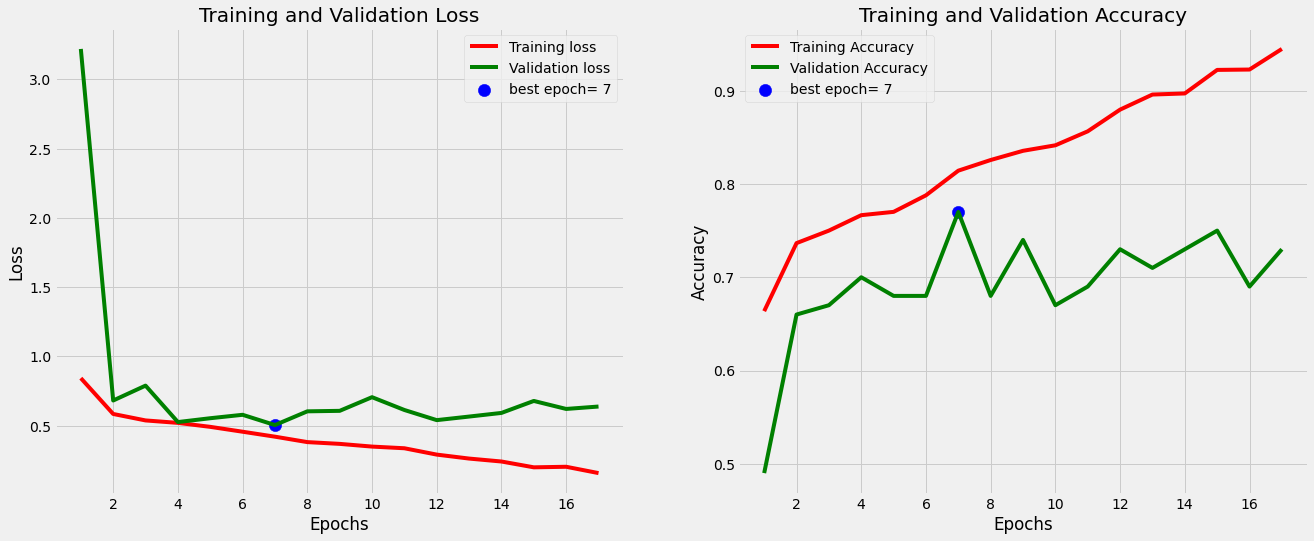

In [ ]:
tr_plot(results)

## 4-2. 모델 실제 정확도
- Test 데이터 사용

In [ ]:
evl_test = model.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps)

acc_test = evl_test[1]* 100
loss_test = evl_test[0]
print('정확도 : %5.2f' % (acc_test))
print('오차 : %5.2f' % (loss_test))

3/3 [==============================] - 59s 29s/step - loss: 0.4652 - accuracy: 0.7833
정확도 : 78.33
오차 :  0.47


## 4-3. 이미지 분류 결과

In [ ]:
errors=int(len(test_file_names)*(1-acc_test/100)) +1
rows=int(errors/5)+1
height=rows * 5
preds=model.predict(test_gen, batch_size=test_batch_size, verbose=0, steps=test_steps)
plt.figure(figsize=(20,height ))
j=1
for i,p in enumerate(preds):
    index=np.argmax(p)
    prob=p[index]
    label=test_gen.labels[i]
    if index != label:
        img_path=os.path.join(test_dir,test_file_names[i] )
        plt.subplot(rows, 5, j)
        j=j + 1
        if j>errors:
            break
        img = Image.open(img_path)
        img=img.resize((224,224))     
        plt.axis('off')
        plt.title(test_file_names[i])
        plt.imshow(np.asarray(img)) 
plt.show()